# Bag-of-words classifier with pretrained word embeddings

- During the lecture we will cover the concept of embeddings and the simple word2vec method
- If we have a trained word embeddings model, we can transfer that knowledge into a new task and model (transfer learning)
- What we achieve here: Initialize the weights in the classifier with pretrained word embeddings
- Word embeddings downloaded at: https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

### Read data

In [13]:
import json
import random
with open("data/imdb_train.json") as f:
    data=json.load(f)
random.shuffle(data) 
print(data[0])

# We need to gather the texts, into a list
texts=[one_example["text"] for one_example in data]
labels=[one_example["class"] for one_example in data]
print(texts[:2])
print(labels[:2])

{'class': 'neg', 'text': 'Just finished this movie... saw it on the video shelf and being a Nick Stahl fan I just had to rent it. In all honesty, it probably should have stayed on the shelf. The concept was an interesting one and there were several fairly smart twists and turns but somehow I guessed almost all of them before they came along. And the movie just went a little too far in the end in my opinion... if you have to suffer through a viewing of it you\'ll see what I mean!  On a positive note, Nick Stahl\'s acting was great (especially considering what he had to work with). Eddie Kaye Thomas was also good but he always plays the same type of character... too much Paul Finch from \\American Pie\\" coming through for my liking.  And finally, the worst part of this movie has to be January Jones\' emotionless performance... I guess a pretty face really is all that matters in Hollywood."'}
['Just finished this movie... saw it on the video shelf and being a Nick Stahl fan I just had to

### Use gensim to read the embedding model

In [3]:
from gensim.models import KeyedVectors

#Only grab the 100K most common entries
vector_model=KeyedVectors.load_word2vec_format("data/wiki-news-300d-1M.vec", binary=False, limit=100000)

In [10]:
# sort based on the index to make sure they are in the correct order
words=[k for k,v in sorted(vector_model.vocab.items(), key=lambda x:x[1].index)]
print("Words from embedding model:",len(words))
print("First 50 words:",words[:50])

Words from embedding model: 100000
First 50 words: [',', 'the', '.', 'and', 'of', 'to', 'in', 'a', '"', ':', ')', 'that', '(', 'is', 'for', 'on', '*', 'with', 'as', 'it', 'The', 'or', 'was', "'", "'s", 'by', 'from', 'at', 'I', 'this', 'you', '/', 'are', '=', 'not', '-', 'have', '?', 'be', 'which', ';', 'all', 'his', 'has', 'one', 'their', 'about', 'but', 'an', '|']


### Normalize the vectors

- Easier to learn on top of these vectors when the magnitude does not vary much

In [11]:
print("Before normalization:",vector_model.get_vector("in")[:10])
vector_model.init_sims(replace=True)
print("After normalization:",vector_model.get_vector("in")[:10])

Before normalization: [-0.0234 -0.0268 -0.0838  0.0386 -0.0321  0.0628  0.0281 -0.0252  0.0269
 -0.0063]
After normalization: [-0.0163762  -0.01875564 -0.05864638  0.02701372 -0.02246478  0.04394979
  0.01966543 -0.0176359   0.01882563 -0.00440898]


### Text analyzer and vectorizer

- When we use an embedding layer (keras.layers.Embedding) the input data must be a sequence, not a bag-of-words vector
- You can use CountVectorizer only as an analyzer without building the feature matrix
- We will then build the vectorizer part later ourselves

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy
analyzer=CountVectorizer(lowercase=False).build_analyzer() # includes tokenizer and preprocessing
print(analyzer(texts[0]))



['Just', 'finished', 'this', 'movie', 'saw', 'it', 'on', 'the', 'video', 'shelf', 'and', 'being', 'Nick', 'Stahl', 'fan', 'just', 'had', 'to', 'rent', 'it', 'In', 'all', 'honesty', 'it', 'probably', 'should', 'have', 'stayed', 'on', 'the', 'shelf', 'The', 'concept', 'was', 'an', 'interesting', 'one', 'and', 'there', 'were', 'several', 'fairly', 'smart', 'twists', 'and', 'turns', 'but', 'somehow', 'guessed', 'almost', 'all', 'of', 'them', 'before', 'they', 'came', 'along', 'And', 'the', 'movie', 'just', 'went', 'little', 'too', 'far', 'in', 'the', 'end', 'in', 'my', 'opinion', 'if', 'you', 'have', 'to', 'suffer', 'through', 'viewing', 'of', 'it', 'you', 'll', 'see', 'what', 'mean', 'On', 'positive', 'note', 'Nick', 'Stahl', 'acting', 'was', 'great', 'especially', 'considering', 'what', 'he', 'had', 'to', 'work', 'with', 'Eddie', 'Kaye', 'Thomas', 'was', 'also', 'good', 'but', 'he', 'always', 'plays', 'the', 'same', 'type', 'of', 'character', 'too', 'much', 'Paul', 'Finch', 'from', 'Amer

### Expand the vocabulary using words from the embedding model

- The embedding model usually knows more words than the task specific model, because it has seen a lot more data
- If you wish, you can use the embedding model vocabulary to expand the task specific one

In [8]:
# init the vectorizer vocabulary using words from the embedding model
def init_vocabulary(vocab, text, text_analyzer):
    for word in analyzer(text):
        vocab.setdefault(word, len(vocab))
    return vocab

words_from_model=" ".join(words[:50000]) # use 50K words from the embedding model to initialize the vocabulary --> expands the learned vocabulary
vocabulary={"<SPECIAL>": 0} # zero has a special meaning in sequence models, prevent using it for a normal word
vocabulary=init_vocabulary(vocabulary, words_from_model, analyzer)
print("Words from embedding model:",len(vocabulary))


Words from embedding model: 47944


### Vectorizer

- Build a dictionary to turn words into numbers, here we use the one which we initialized with the embedding model
- Vectorizing a sequence: In our data each example is a list of words, we need to turn each example into list of numbers

In [9]:
def vectorizer(vocab, texts):
    vectorized_data=[] # turn text into numbers based on our vocabulary mapping
    for one_example in texts:
        vectorized_example=[]
        for word in analyzer(one_example):
            vocab.setdefault(word, len(vocab)) # add word to our vocabulary if it does not exist
            vectorized_example.append(vocab[word])
        vectorized_data.append(vectorized_example)
    
    vectorized_data=numpy.array(vectorized_data) # turn python list into numpy matrix
    return vectorized_data, vocab

vectorized_data, vocabulary=vectorizer(vocabulary, texts)

# now vectorized data is the same as feature_matrix, but in different format
print("Words in vocabulary:",len(vocabulary))
print("Vectorized data shape:",vectorized_data.shape)
print("First example vectorized:",vectorized_data[0])
inversed_vocabulary={value:key for key, value in vocabulary.items()} # inverse the dictionary
print("First example text:",[inversed_vocabulary[idx] for idx in vectorized_data[0]])
        

Words in vocabulary: 105571
Vectorized data shape: (25000,)
First example vectorized: [23, 5824, 75, 3, 31, 2414, 74, 2185, 177, 107, 15, 29, 3, 1, 3834, 2414, 23, 463, 481, 405, 165, 109, 6573, 97, 33, 2672, 3, 12, 333, 23, 87, 5, 19132, 6, 633, 841, 12, 5, 1, 3317, 55, 12, 524, 75, 121, 725, 5317, 110, 1322, 1, 106, 32, 2225, 6, 25615, 5923, 3194, 12287, 5, 12, 113, 333, 23, 194, 2336, 84, 4, 24, 12742, 74, 47, 9328, 9, 12, 266, 47944, 47945, 47946]
First example text: ['have', 'walked', 'out', 'of', 'about', 'movies', 'my', 'entire', 'life', 'This', 'was', 'one', 'of', 'the', 'worst', 'movies', 'have', 'ever', 'seen', 'don', 'know', 'how', 'sat', 'through', 'an', 'hour', 'of', 'it', 'must', 'have', 'been', 'in', 'coma', 'that', 'night', 'saw', 'it', 'in', 'the', 'theatre', 'when', 'it', 'came', 'out', 'years', 'ago', 'couldn', 'even', 'remember', 'the', 'name', 'but', 'knew', 'that', 'Penelope', 'Ann', 'Miller', 'starred', 'in', 'it', 'It', 'must', 'have', 'really', 'affected', 'me'

### Labels into numerical vectors

- Same as in the original BOW classifier

In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoder=LabelEncoder() #Turns class labels into integers
class_numbers=label_encoder.fit_transform(labels)
print("class_numbers shape=",class_numbers.shape)
print("class_numbers",class_numbers)
print("class labels",label_encoder.classes_)


class_numbers shape= (25000,)
class_numbers [0 0 1 ... 0 0 1]
class labels ['neg' 'pos']


## Network

- First we need to create an embedding matrix which we can then plug into the neural network
- The embedding matrix must follow the order from the vectorizer

In [11]:
def load_pretrained_embeddings(vocab, embedding_model):
    """ vocab: vocabulary from our data vectorizer, embedding_model: model loaded with gensim """
    pretrained_embeddings=numpy.random.uniform(low=-0.05, high=0.05, size=(len(vocab),embedding_model.vectors.shape[1])) # initialize new matrix (words x embedding dim)
    found=0
    for word,idx in vocab.items():
        if word in embedding_model.vocab:
            pretrained_embeddings[idx]=embedding_model.get_vector(word)
            found+=1
            
    print("Found pretrained vectors for {found} words.".format(found=found))
    return pretrained_embeddings

pretrained=load_pretrained_embeddings(vocabulary, vector_model)
print("Shape of pretrained embeddings:",pretrained.shape)
print("Vector for the word 'in':",pretrained[vocabulary["in"]][:10])


Found pretrained vectors for 63848 words.
Shape of pretrained embeddings: (105571, 300)
Vector for the word 'in': [-0.0163762  -0.01875564 -0.05864638  0.02701372 -0.02246478  0.04394979
  0.01966543 -0.0176359   0.01882563 -0.00440898]


### Sequential input

- Remember how the shape of the input data matrix had undefined number of columns
- Now we must make it into fixed size (same for each example)
- Padding: include zeros until you reach the correct size
- You will hear more about this next week!

In [13]:
from keras.preprocessing.sequence import pad_sequences
print("Old shape:", vectorized_data.shape)
vectorized_data_padded=pad_sequences(vectorized_data, padding='post')
print("New shape:", vectorized_data_padded.shape)
print("First example:", vectorized_data_padded[0])

Old shape: (25000,)
New shape: (25000, 2366)
First example: [  23 5824   75 ...    0    0    0]


Now we need to define a new keras layer for later use. You should not need anything like this after next weeks when we will show you convolutional layers and LSTMs.

In [19]:
from keras.layers import Layer
from keras import backend as K
import tensorflow as tf

class MaskedAveragePooling(Layer):
    def __init__(self, **kwargs):
        self.supports_masking = True
        super(MaskedAveragePooling, self).__init__(**kwargs)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        if mask is not None:
            # mask (batch, time)
            mask = K.cast(mask, K.floatx())
            # mask (batch, x_dim, time)
            mask = K.repeat(mask, x.shape[-1])
            # mask (batch, time, x_dim)
            mask = tf.transpose(mask, perm=[0,2,1])
            x = x * mask
        return K.sum(x, axis=1) / K.sum(mask, axis=1)

    def compute_output_shape(self, input_shape):
        # remove temporal dimension
        return input_shape[0], input_shape[2]

### Our network structure:

- Input layer, Embedding layer with pretrained weights, Average of embeddings, Non-linear activation, Classification layer
- The key point here is the embedding layer

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Activation
from keras import backend as K
from keras.layers.core import Lambda
from keras.optimizers import SGD, Adam


example_count,sequence_len=vectorized_data_padded.shape
class_count=len(label_encoder.classes_)
vector_size=pretrained.shape[1] # embedding dim ("hidden layer") must be the same as in the pretrained model

inp=Input(shape=(sequence_len,))
embeddings=Embedding(len(vocabulary), vector_size, mask_zero=True, weights=[pretrained])(inp)
average_embeddings=MaskedAveragePooling()(embeddings) # custom layer we defined above
tanh=Activation("tanh")(average_embeddings)
outp=Dense(class_count, activation="softmax")(tanh)
model=Model(inputs=[inp], outputs=[outp])

optimizer=Adam(lr=0.001) # define the learning rate
model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=['accuracy'])

print(model.summary())

# train
hist=model.fit(vectorized_data_padded,class_numbers,batch_size=100,verbose=1,epochs=50,validation_split=0.1)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 2366)              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 2366, 300)         31671300  
_________________________________________________________________
masked_average_pooling_5 (Ma (None, 300)               0         
_________________________________________________________________
activation_3 (Activation)    (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 602       
Total params: 31,671,902
Trainable params: 31,671,902
Non-trainable params: 0
_________________________________________________________________
None
Train on 22500 samples, validate on 2500 samples
Epoch 1/50
22500/22500 [==============================] - 3

History: [0.7675999927520752, 0.7840000009536743, 0.7995999956130981, 0.8043999981880188, 0.821999990940094, 0.8323999953269958, 0.842000002861023, 0.8496000003814698, 0.8607999992370605, 0.8672000002861023, 0.8744000029563904, 0.8764000058174133, 0.8792000079154968, 0.881200008392334, 0.8828000044822693, 0.8856000018119812, 0.8872000074386597, 0.8880000042915345, 0.8900000047683716, 0.8912000083923339, 0.8928000092506408, 0.8952000069618226, 0.8971999979019165, 0.8964000010490417, 0.898800003528595, 0.8980000042915344, 0.8960000038146972, 0.8984000039100647, 0.8980000019073486, 0.8984000039100647, 0.9004000043869018, 0.9000000023841858, 0.898400001525879, 0.9, 0.8984000039100647, 0.898400001525879, 0.9000000023841858, 0.9, 0.9, 0.9016000008583069, 0.9004000020027161, 0.9016000032424927, 0.9008000016212463, 0.9000000023841858, 0.903199999332428, 0.9015999984741211, 0.901199996471405, 0.8999999976158142, 0.8996000003814697, 0.9007999992370606]
Max accuracy: 0.903199999332428


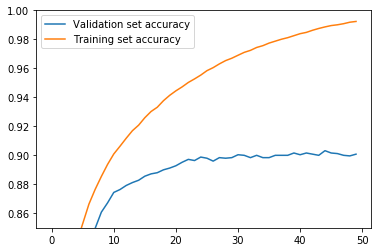

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
print("History:",hist.history["val_acc"])
print("Max accuracy:",numpy.max(hist.history["val_acc"]))
plt.ylim(0.85,1.0)
plt.plot(hist.history["val_acc"],label="Validation set accuracy")
plt.plot(hist.history["acc"],label="Training set accuracy")
plt.legend()
plt.show()